# MLB Project for data from the 2022-2023 season

### Dataset available from https://drive.google.com/drive/folders/1G1WHb3nBpv3xXQY4V6pLo8qI9lHq9X0_?usp=sharing


In [185]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, wilcoxon
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold

In [186]:
df = pd.read_csv(r'2023-mlb-data.csv')
df.shape

(736626, 95)

In [187]:
# Adding more measures to data
# Total Score
df['total_score'] = df['home_score'] + df['away_score']

# Is_strike flag
df['is_strike'] = 0
strike_events = ['called_strike', 'swinging_strike', 'foul', 'swinging_strike_blocked', 'foul_tip', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']
df.loc[df['description'].isin(strike_events), 'is_strike'] = 1



In [188]:
_df = df.loc [:, ['pitcher_name', 'pitch_name', 'is_strike']].groupby(['pitcher_name', 'pitch_name'], as_index=False).count().rename(columns={'is_strike':'n_pitches'})

df2 = df.merge(_df, on=['pitcher_name', 'pitch_name'])

df2 = df2.loc[df2['n_pitches']>=100]

df2['runs_scored'] = df2['post_bat_score'] - df2['bat_score']

In [189]:
df2['runs_scored'].describe()

count    672545.000000
mean          0.028695
std           0.209070
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: runs_scored, dtype: float64

In [190]:
# Create Era dataframe/dataset
era = df2.loc[:, ['pitcher_name', 'pitcher', 'runs_scored']].groupby(['pitcher_name', 'pitcher'], as_index=False).sum()

# create innings data for era df
_df = df2.loc[:, ['pitcher', 'game_pk', 'inning']].drop_duplicates()
_df = _df['pitcher'].value_counts().to_frame().reset_index().rename(columns={'count':'n_innings'})

# merge temp df to era df
era = era.merge(_df, on=['pitcher'])

# create era metric
era['era'] = (era['runs_scored']/era['n_innings'])*9

era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era
0,"Abbott, Cory",676265,25,52,4.326923
1,"Abreu, Albert",656061,12,51,2.117647
2,"Abreu, Bryan",650556,26,81,2.888889
3,"Acevedo, Domingo",642758,32,82,3.512195
4,"Adam, Jason",592094,14,77,1.636364


Create strikeouts per 9 on ERA dataframe

In [191]:
strikeout_events = ['strikeout', 'strikeout_double_play']
df2['strikeout'] = 0
df2.loc[df2['events'].isin(strikeout_events), 'strikeout'] = 1

_df = df2.loc[:, ['pitcher_name', 'pitcher', 'strikeout']].groupby(['pitcher_name', 'pitcher'], as_index=False).sum()

era = era.merge(_df, on=['pitcher_name', 'pitcher'])

In [192]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout
0,"Abbott, Cory",676265,25,52,4.326923,45
1,"Abreu, Albert",656061,12,51,2.117647,29
2,"Abreu, Bryan",650556,26,81,2.888889,101
3,"Acevedo, Domingo",642758,32,82,3.512195,58
4,"Adam, Jason",592094,14,77,1.636364,77


In [193]:
era['strikeouts_per_9'] = (era['strikeout']/era['n_innings'])*9
era.head(20)

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000
5,"Adon, Joan",672851,50,75,6.000000,48,5.760000
6,"Akin, Keegan",669211,37,104,3.201923,79,6.836538
7,"Alberto, Hanser",593643,5,11,4.090909,1,0.818182
8,"Alcantara, Sandy",645261,65,232,2.521552,207,8.030172
9,"Alexander, Jason",669920,46,76,5.447368,42,4.973684


In [194]:
# Add FIP Fielder Independent pitching 3 + (((home_run*13)+(walk*3) - (strikeout*2) / (n_innings))

df2['walk'] = 0
df2.loc[df2['events'] == 'walk', 'walk'] = 1

df2['home_run'] = 0
df2.loc[df2['events']=='home_run', 'home_run'] = 1

_df = df2.loc[:, ['pitcher_name', 'pitcher', 'walk', 'home_run']].groupby(['pitcher_name', 'pitcher'], as_index=False).sum()

era = era.merge(_df, on=['pitcher_name', 'pitcher'])

In [195]:
era['fip'] = 3 + (((era['home_run']*13) + (era['walk']*3) - (era['strikeout']*2)) / (era['n_innings']))

In [196]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9,walk,home_run,fip
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571


ERA Data viz playing around with seaborn

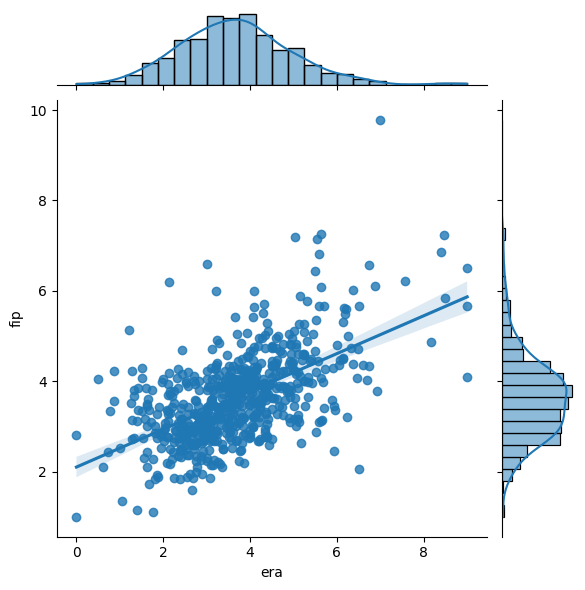

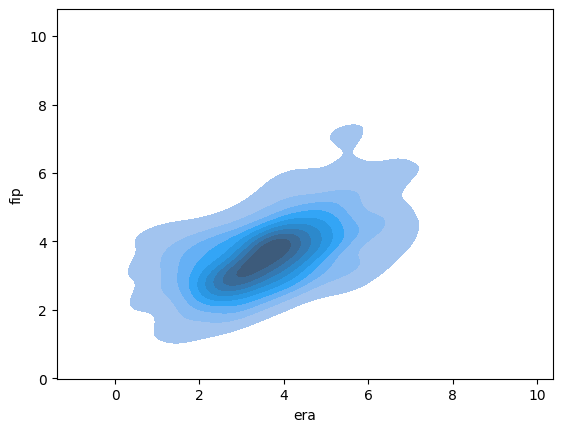

In [197]:
sns.jointplot(data=era, x='era', y='fip', kind='reg')
plt.show()

sns.kdeplot(data=era, x='era', y='fip', fill=True)
plt.show()

In [198]:
era.loc[:, ['fip', 'era', 'strikeouts_per_9']].describe()

,fip,era,strikeouts_per_9
count,632.000000,632.000000,632.000000
mean,3.647499,3.693438,6.821710
std,0.986905,1.345245,2.378792
min,1.000000,0.000000,0.000000
25%,2.983871,2.789156,5.435526
50%,3.577381,3.613715,6.950957
75%,4.128828,4.414468,8.417677
max,9.777778,9.000000,15.464789


In [199]:
era['era'].median(), era['era'].quantile(.5)

(3.613715077349342, 3.613715077349342)

In [200]:
# Pearson R
era.loc[:, ['fip', 'era', 'strikeouts_per_9']].corr()

,fip,era,strikeouts_per_9
fip,1.000000,0.570359,-0.422666
era,0.570359,1.000000,0.012890
strikeouts_per_9,-0.422666,0.012890,1.000000


In [201]:
#R2 value 
era.loc[:, ['fip', 'era', 'strikeouts_per_9']].corr()**2

,fip,era,strikeouts_per_9
fip,1.000000,0.325309,0.178646
era,0.325309,1.000000,0.000166
strikeouts_per_9,0.178646,0.000166,1.000000


In [202]:
#add plus metric over the era mean
era['era_plus'] = (era['era'] / era['era'].mean())*100

In [203]:
era['era_plus'].describe()

count    632.000000
mean     100.000000
std       36.422553
min        0.000000
25%       75.516510
50%       97.841486
75%      119.521900
max      243.675373
Name: era_plus, dtype: float64

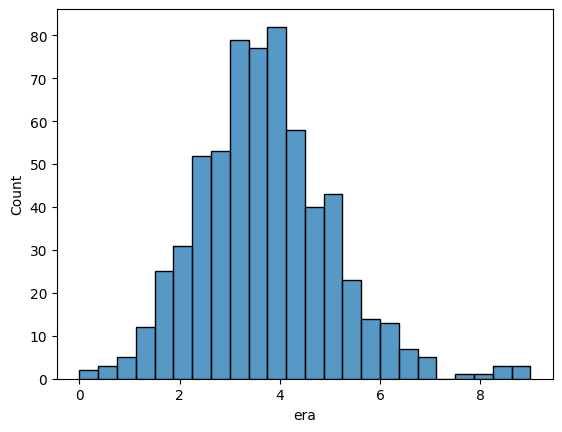

In [204]:
sns.histplot(era['era'])
plt.show()

Explained Variances

In [205]:
r = pearsonr(era['era'], era['fip'])
r2 = r[0]**2

r[0], r2, r[1]

(0.5703586023830288, 0.32530893531232197, 8.17706915622145e-56)

In [206]:
sr = spearmanr(era['era'],era['fip'])
sr2 = sr[0]**2
sr[0], sr2, sr[-1]

(0.5516708095343142, 0.30434068209224563, 1.2995460922250619e-51)

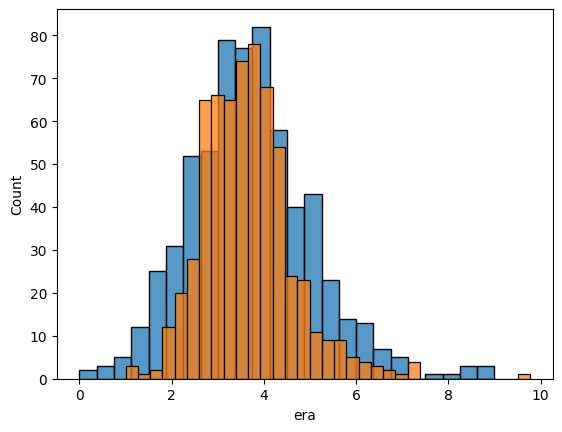

In [207]:
sns.histplot(era['era'])
sns.histplot(era['fip'])
plt.show()

In [208]:
t = ttest_ind(era['era'], era['fip'])
t[0], t[1]

(0.6922148794504963, 0.4889297355691794)

In [209]:
t_title = f"t-value: {round(t[0],3)}"

rmse = mean_squared_error(era['era'], era['fip'])**0.5

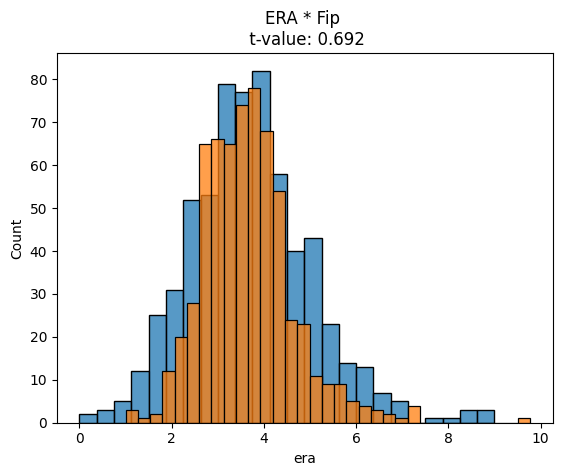

In [210]:
sns.histplot(era['era'])
sns.histplot(era['fip'])
plt.title(f'ERA * Fip \n {t_title}')
plt.show()

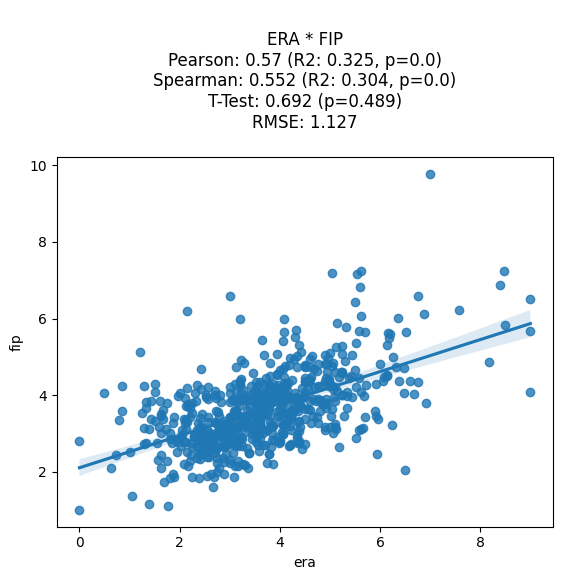

In [211]:
title_str = f"""
ERA * FIP
Pearson: {round(r[0], 3)} (R2: {round(r2, 3)}, p={round(r[-1], 3)})
Spearman: {round(sr[0], 3)} (R2: {round(sr2, 3)}, p={round(sr[1], 3)})
T-Test: {round(t[0], 3)} (p={round(t[-1], 3)})
RMSE: {round(rmse, 3)}
"""

sns.regplot(data=era, x='era', y='fip')
plt.title(title_str)
plt.show()

In [212]:
train = era.sample(100, random_state=1)
test = era.sample(100, random_state=2)

In [213]:
train.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9,walk,home_run,fip,era_plus
101,"Civale, Aaron",650644,50,106,4.245283,100,8.490566,24,14,3.509434,114.941214
575,"Uelmen, Erich",657272,17,35,4.371429,20,5.142857,10,3,3.828571,118.356610
407,"Norris, Daniel",596057,29,74,3.527027,68,8.270270,24,10,3.891892,95.494403
441,"Poche, Colin",621363,30,69,3.913043,64,8.347826,22,11,4.173913,105.945815
223,"Gutierrez, Vladimir",661269,26,41,5.707317,26,5.707317,19,8,5.658537,154.525847


In [214]:
test.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9,walk,home_run,fip,era_plus
377,"Minter, A.J.",621345,26,85,2.752941,98,10.376471,15,5,1.988235,74.535997
601,"Weems, Jordan",607179,25,52,4.326923,36,6.230769,9,6,3.634615,117.151622
107,"Cole, Gerrit",543037,84,231,3.272727,285,11.103896,56,36,3.285714,88.609227
484,"Ryan, Joe",657746,57,152,3.375000,146,8.644737,47,20,3.717105,91.378265
251,"Holmes, Clay",605280,24,85,2.541176,68,7.200000,19,2,2.376471,68.802458


In [215]:
def make_corr(df, title_name=' '):
    
    r = pearsonr(df['era'], df['fip'])
    r2 = r[0]**2

    sr = spearmanr(df['era'], df['fip'])
    sr2 = sr[0]**2

    t = ttest_ind(df['era'], df['fip'])

    rmse = mean_squared_error(df['era'], df['fip'])**0.5

    title_str = f"""
    {title_name}
    ERA * FIP
    Pearson: {round(r[0], 3)} (R2: {round(r2, 3)}, p={round(r[-1], 3)})
    Spearman: {round(sr[0], 3)} (R2: {round(sr2, 3)}, p={round(sr[1], 3)})
    T-Test: {round(t[0], 3)} (p={round(t[-1], 3)})
    RMSE: {round(rmse, 3)}
    """

    sns.regplot(data=df, x='era', y='fip')
    plt.title(title_str)
    plt.show()

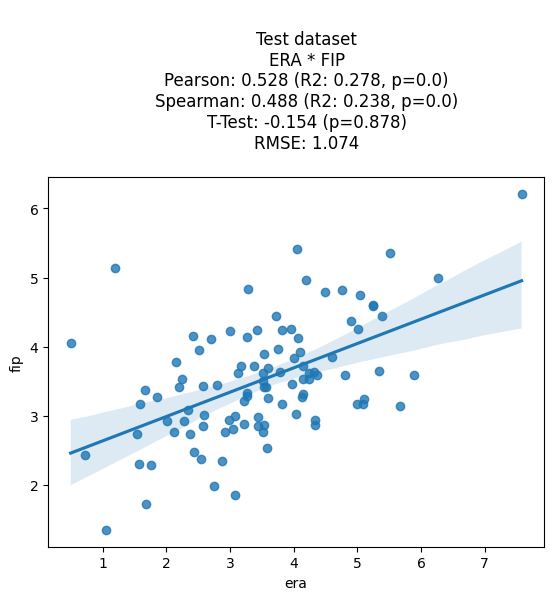

In [216]:
make_corr(test, title_name='Test dataset')

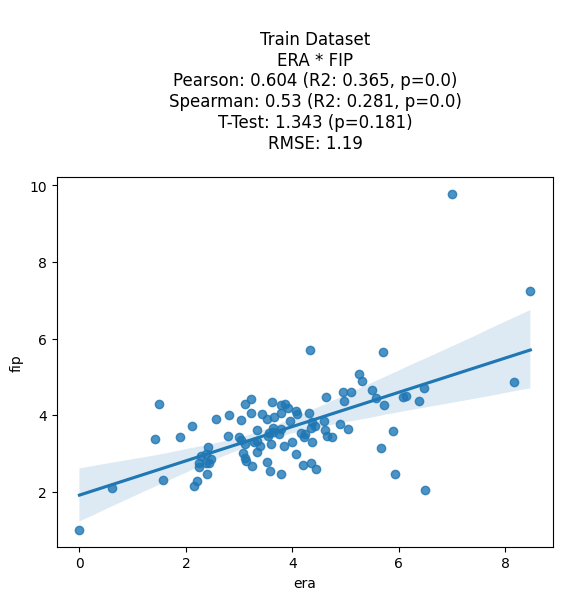

In [217]:
make_corr(train, title_name='Train Dataset')

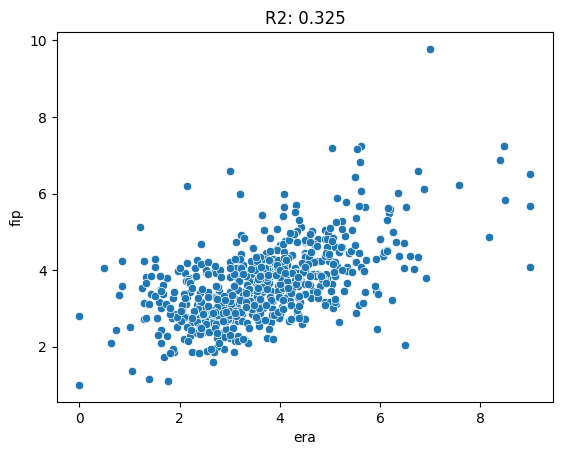

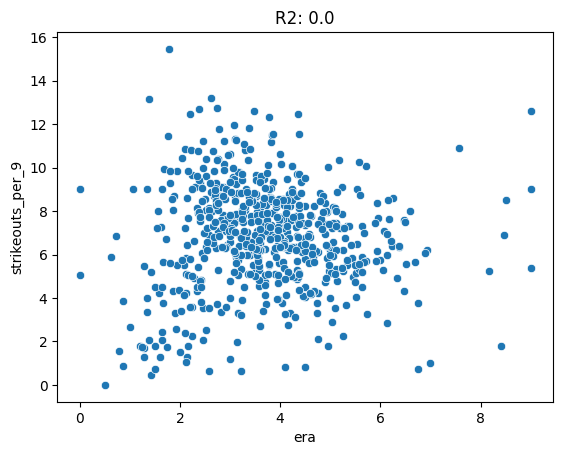

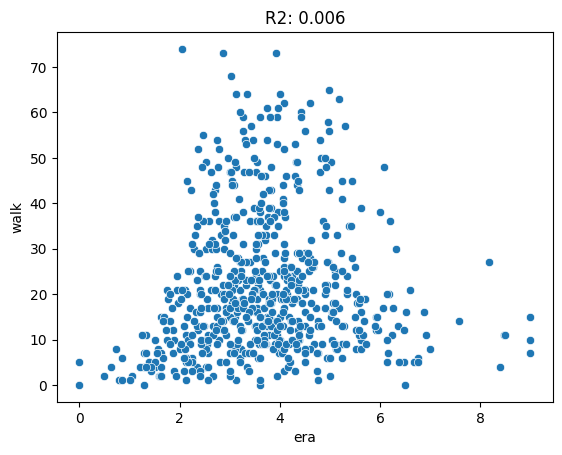

In [218]:
for col in ['fip', 'strikeouts_per_9', 'walk']:
    r2 = pearsonr(era['era'], era[col])[0]**2
    sns.scatterplot(data=era, x='era', y=col)
    plt.title(f'R2: {round(r2,3)}')
    plt.show()

Machine Learning

Slope intercept formula y = mx + b

ERA = weight of FIP * FIP + the value where Y = 0


In [219]:
target = 'era'
features = ['fip']

era.loc[:, features+[target]].head()

,fip,era
0,5.711538,4.326923
1,2.764706,2.117647
2,1.938272,2.888889
3,3.487805,3.512195
4,2.428571,1.636364


In [220]:
#create model
model = LinearRegression()

#find slope and y intercept
model.fit(era.loc[:, features], era[target])

LinearRegression()

In [221]:
model.coef_

array([0.77745294])

In [222]:
model.intercept_

0.857680025417455

In [223]:
#Weight of FIP
ws = pd.DataFrame([model.coef_], columns=features)
ws

,fip
0,0.777453


In [224]:
# B value
b = model.intercept_

In [225]:
col = 'fip'

era[f'{target}_pred'] = ws[col].values[0] * era[col] + b

In [226]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9,walk,home_run,fip,era_plus,era_pred
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622,5.298132
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382,3.007109
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787,2.364595
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829,3.569284
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613,2.745780


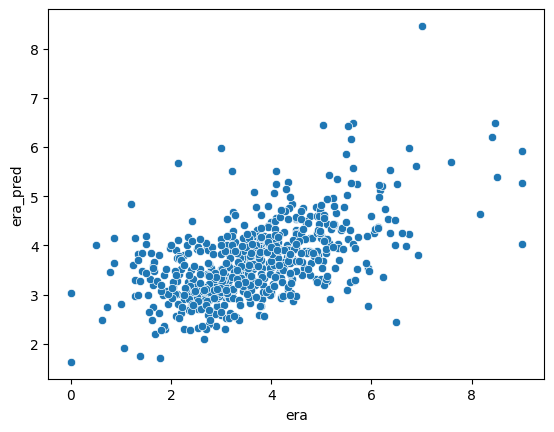

In [227]:
sns.scatterplot(data=era, x=target, y=f'{target}_pred')
plt.show()

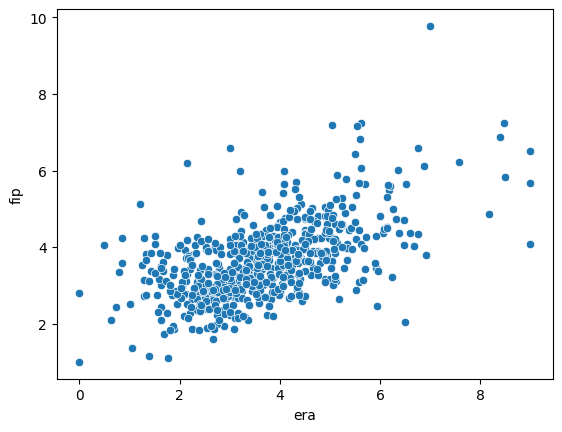

In [228]:
sns.scatterplot(data=era, x=target, y='fip')
plt.show()

In [229]:
target = 'era'
features = ['fip','strikeouts_per_9']

era.loc[:, features+[target]].head()

,fip,strikeouts_per_9,era
0,5.711538,7.788462,4.326923
1,2.764706,5.117647,2.117647
2,1.938272,11.222222,2.888889
3,3.487805,6.365854,3.512195
4,2.428571,9.000000,1.636364


In [230]:
model = LinearRegression()
model.fit(era.loc[:, features], era[target])
ws = pd.DataFrame([model.coef_], columns=features)

ws

,fip,strikeouts_per_9
0,0.955593,0.174857


In [231]:
col = 'fip'

for col in features:
    era[f'{col}_w'] = ws[col].values[0] * era[col]

era[f'{target}_pred'] = era['fip_w'] + era['strikeouts_per_9_w'] + b
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9,walk,home_run,fip,era_plus,era_pred,fip_w,strikeouts_per_9_w
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622,7.677449,5.457904,1.361864
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382,4.394467,2.641933,0.894855
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787,4.672158,1.852198,1.962280
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829,5.303713,3.332921,1.113112
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613,4.752115,2.320725,1.573710


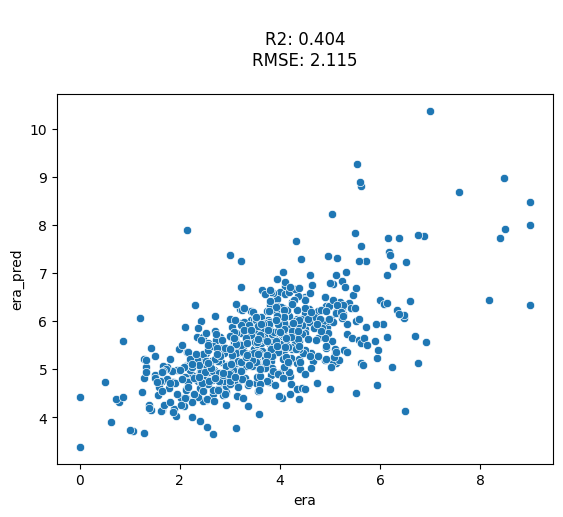

In [232]:
r2 = pearsonr(era[target], era[f'{target}_pred'])[0]**2
rmse = mean_squared_error(era[target], era[f'{target}_pred'])**0.5
sns.scatterplot(data=era, x=target, y=f'{target}_pred')
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""
plt.title(title_str)
plt.show()

In [233]:
target = 'era'
features = ['fip','strikeouts_per_9']
model = LinearRegression()
model.fit(era.loc[:, features], era[target])
era[f'{target}_pred'] = model.predict(era.loc[:, features])

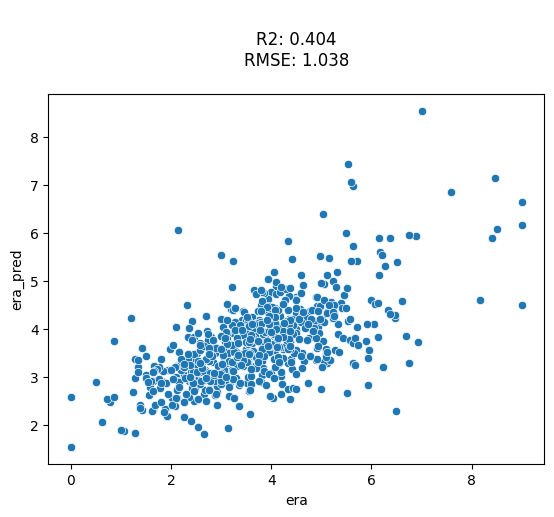

In [234]:
r2 = pearsonr(era[target], era[f'{target}_pred'])[0]**2
rmse = mean_squared_error(era[target], era[f'{target}_pred'])**0.5
sns.scatterplot(data=era, x=target, y=f'{target}_pred')
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""
plt.title(title_str)
plt.show()

In [235]:
train = era.sample(100, random_state=1)
test = era.sample(100, random_state=2)

target = 'era'
features = ['fip','strikeouts_per_9']
model = LinearRegression()
model.fit(train.loc[:, features], train[target])
test[f'{target}_pred'] = model.predict(test.loc[:, features])

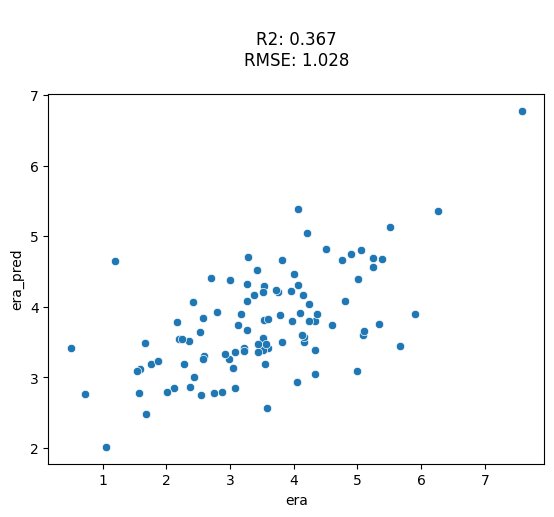

In [236]:
r2 = pearsonr(test[target], test[f'{target}_pred'])[0]**2
rmse = mean_squared_error(test[target], test[f'{target}_pred'])**0.5
sns.scatterplot(data=test, x=target, y=f'{target}_pred')
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""
plt.title(title_str)
plt.show()

In [237]:
train = era.sample(100, random_state=10)
test = era.sample(100, random_state=20)

target = 'era'
features = ['fip','strikeouts_per_9', 'walk', 'home_run']
model = LinearRegression()
model.fit(train.loc[:, features], train[target])
test[f'{target}_pred'] = model.predict(test.loc[:, features])

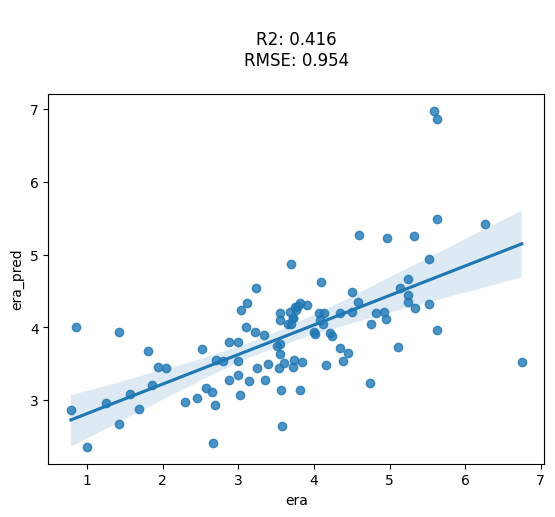

In [238]:
r2 = pearsonr(test[target], test[f'{target}_pred'])[0]**2
rmse = mean_squared_error(test[target], test[f'{target}_pred'])**0.5
sns.regplot(data=test, x=target, y=f'{target}_pred')
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""
plt.title(title_str)
plt.show()

Overlapping values check

In [239]:
train = era.sample(100, random_state=10)
test = era.sample(100, random_state=20)



In [240]:
train.loc[:, ['pitcher_name', 'pitcher']].merge(test.loc[:, ['pitcher_name', 'pitcher']])

,pitcher_name,pitcher
0,"Jax, Griffin",643377
1,"Sulser, Cole",642121
2,"Velasquez, Vince",592826
3,"McCullers Jr., Lance",621121
4,"Beeks, Jalen",656222
5,"Thompson, Zach",605507
6,"Fried, Max",608331
7,"Bird, Jake",656234
8,"Foley, Jason",671345
9,"Ashcraft, Graham",668933


Distinct samples for datasets

In [241]:
train, test = train_test_split(era, random_state=1)

In [242]:
train.loc[:, ['pitcher_name', 'pitcher']].merge(test.loc[:, ['pitcher_name', 'pitcher']])

,pitcher_name,pitcher


In [243]:
target = 'era'
features = ['fip','strikeouts_per_9']
model = LinearRegression()
model.fit(train.loc[:, features], train[target])
test[f'{target}_pred'] = model.predict(test.loc[:, features])

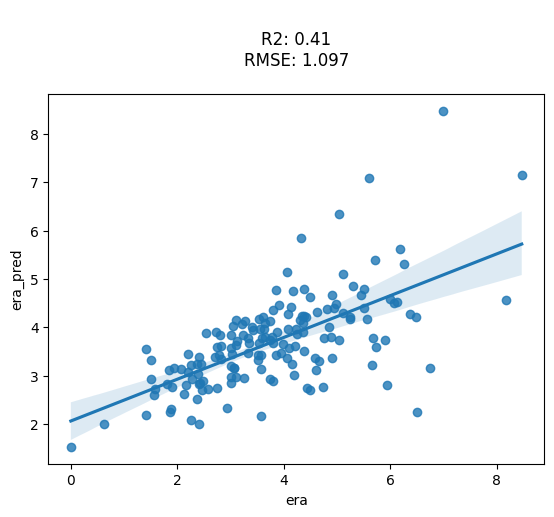

In [244]:
r2 = pearsonr(test[target], test[f'{target}_pred'])[0]**2
rmse = mean_squared_error(test[target], test[f'{target}_pred'])**0.5
sns.regplot(data=test, x=target, y=f'{target}_pred')
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""
plt.title(title_str)
plt.show()

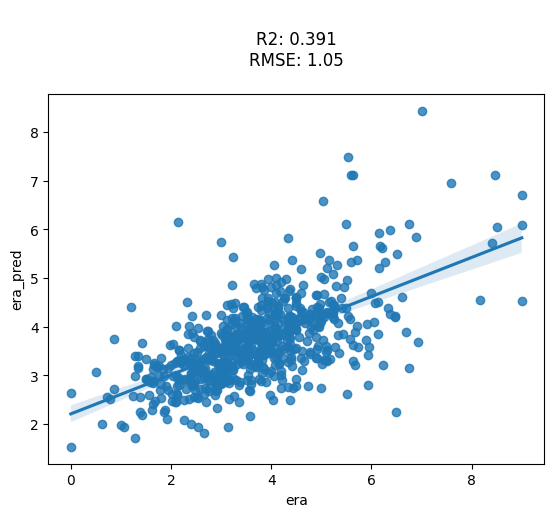

In [248]:
#Kfold - K = Number of times you want to FOLD

target = 'era'
features = ['fip','strikeouts_per_9']

kf = KFold(5, shuffle=True, random_state=1) #shuffle protects against anything linear or sequential in datasets

#create out of sample pd.series
oos_preds = pd.Series(dtype=float)

for train_index, test_index in kf.split(era):
    train = era.loc[train_index]
    test = era.loc[test_index]

    model = LinearRegression()
    model.fit(train.loc[:, features], train[target])
    test[f'{target}_pred'] = model.predict(test.loc[:, features])

    oos_preds = pd.concat([oos_preds, test[f'{target}_pred']])

# join oos on to era dataframe
era[f'{target}_pred'] = oos_preds

r2 = pearsonr(era[target], era[f'{target}_pred'])[0]**2
rmse = mean_squared_error(era[target], era[f'{target}_pred'])**0.5
sns.regplot(data=era, x=target, y=f'{target}_pred')
title_str = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""
plt.title(title_str)
plt.show()

In [246]:
oos_preds

0      5.823936
11     4.287317
13     2.596640
17     4.114682
23     4.221286
         ...   
596    4.618319
603    4.301208
613    2.944252
625    6.710083
626    3.706345
Length: 632, dtype: float64

In [247]:
era.head(20)

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,strikeouts_per_9,walk,home_run,fip,era_plus,era_pred,fip_w,strikeouts_per_9_w
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622,5.823936,5.457904,1.361864
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382,2.602906,2.641933,0.894855
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787,2.833534,1.852198,1.962280
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829,3.508284,3.332921,1.113112
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613,2.887624,2.320725,1.573710
5,"Adon, Joan",672851,50,75,6.000000,48,5.760000,38,9,4.800000,162.450249,4.691963,4.586845,1.007174
6,"Akin, Keegan",669211,37,104,3.201923,79,6.836538,21,11,3.461538,86.692200,3.525325,3.307821,1.195414
7,"Alberto, Hanser",593643,5,11,4.090909,1,0.818182,3,2,6.000000,110.761533,5.001261,5.733556,0.143065
8,"Alcantara, Sandy",645261,65,232,2.521552,207,8.030172,49,16,2.745690,68.271118,3.050930,2.623761,1.404129
9,"Alexander, Jason",669920,46,76,5.447368,42,4.973684,28,12,5.052632,147.487726,4.815321,4.828258,0.869682
